In [12]:
import sys, os
sys.path.append('/home/A00512318/TCN')
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from TCN.mnist_pixel.utils import data_generator
from TCN.mnist_pixel.model import TCN
import numpy as np
import argparse

In [13]:
# set default values for model
batch_size = 32
cuda = True
dropout = 0.05
clip = -1
epochs = 20
kernel_size = 7
levels = 8
log_interval = 100
lr = 4e-3
optimm = 'Adam'
nhid = 25
seed = 1111
permutee = False
root = '../data/fashion_mnist'
input_channels = 1
n_classes = 10
seq_length = int(784 / input_channels)
steps = 0

In [14]:
from torchvision import datasets, transforms

def data_generator(root, batch_size):
    train_set = datasets.FashionMNIST(root=root, train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))
    test_set = datasets.FashionMNIST(root=root, train=False, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                              ]))

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

train_loader, test_loader = data_generator(root, batch_size)

classes = ('tshit/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle/boot')
print(classes)

('tshit/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle/boot')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3])
ankle/boot tshit/top tshit/top dress tshit/top pullover sneaker pullover sandal sandal tshit/top ankle/boot sandal sandal sneaker ankle/boot trouser tshit/top shirt  coat dress trouser  coat   bag  coat dress tshit/top pullover  coat  coat sandal dress


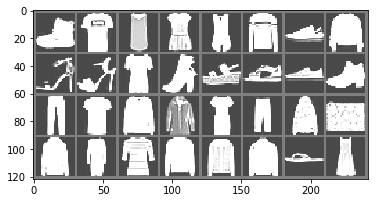

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8])
ankle/boot pullover trouser trouser shirt trouser  coat shirt sandal sneaker  coat sandal sneaker dress  coat trouser pullover  coat   bag tshit/top pullover sandal sneaker ankle/boot trouser  coat shirt tshit/top ankle/boot dress   bag   bag


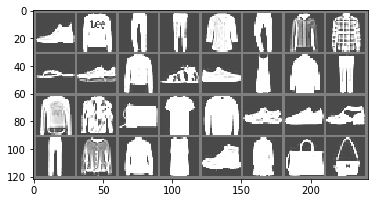

In [16]:
# sanity check for validation data
dataiter = iter(test_loader)
images, labels = dataiter.next()
print(labels)
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [17]:
permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
channel_sizes = [nhid] * levels
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)

model.cuda()
permute = permute.cuda()
optimizer = getattr(optim, optimm)(model.parameters(), lr=lr)

In [18]:
def trainTCN(ep):
    global steps
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda: 
            data, target = data.cuda(), target.cuda()
        data = data.view(-1, input_channels, seq_length)
        if permutee:
            data = data[:, :, permute]
#         data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        if clip > 0:
            torch.nn.utils.clip_grad_norm(model.parameters(), clip)
        optimizer.step()
        train_loss += loss
        steps += seq_length
        if batch_idx > 0 and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tSteps: {}'.format(
                ep, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss.data[0]/log_interval, steps))
            train_loss = 0

In [19]:
def testTCN():
#     model.eval()
    test_loss = 0
    correct = 0
    correct_class = list(0. for i in range(10))
    correct_total = list(0. for i in range(10))
    tot = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda() # move devices to cuda
            data = data.view(-1, input_channels, seq_length)
            if permutee:
                data = data[:, :, permute]
#             data, target = Variable(data, volatile=True), Variable(target)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).data[0]
#             _, pred = output.data.max(1, keepdim=True)
            _, pred = torch.max(output, 1)
#             print(pred)
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
#             print(len(target.data.view_as(pred)))
            c = (pred == target).squeeze()
            tot += 1
            if tot != 313:
                for i in range(batch_size):
#                     print(pred[i], target.data.view_as(pred)[i])
                    label = pred[i]
                    if (pred[i] == target.data.view_as(pred)[i]):
                        correct_class[label] += c[i].item()
                    correct_total[label] += 1
                    
                
#     print(tot)
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * correct_class[i] / correct_total[i]))

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [39]:
def save(model):
    torch.save(model, save_filename)
    print('Saved as %s' % save_filename)

In [10]:
for epoch in range(1, epochs+1):
        trainTCN(epoch)
        testTCN()
        if epoch % 5 == 0: 
            print('Saving model.....')
            save(model) 
        if epoch % 10 == 0:
            lr /= 10
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

/home/A00512318/anaconda3/envs/tcn/lib/python3.7/site-packages/ipykernel/__main__.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.545107	Steps: 79184
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.898625	Steps: 157584
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.744507	Steps: 235984
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.651251	Steps: 314384
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.598983	Steps: 392784
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.619768	Steps: 471184
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.583221	Steps: 549584
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.539906	Steps: 627984
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.537989	Steps: 706384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.502720	Steps: 784784
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.493982	Steps: 863184
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.515455	Steps: 941584
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.482819	Steps: 1019984
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.481882	Steps: 1098384
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.476238	Steps: 1176784
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0

/home/A00512318/anaconda3/envs/tcn/lib/python3.7/site-packages/ipykernel/__main__.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/A00512318/anaconda3/envs/tcn/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/A00512318/anaconda3/envs/tcn/lib/python3.7/site-packages/ipykernel/__main__.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test set: Average loss: 0.4609, Accuracy: 8320/10000 (83%)

Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.442790	Steps: 1549184
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.436573	Steps: 1627584
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.445840	Steps: 1705984
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.415991	Steps: 1784384
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.421147	Steps: 1862784
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.450325	Steps: 1941184
Train Epoch: 2 [22400/60000 (37%)]	Loss: 0.407459	Steps: 2019584
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.416385	Steps: 2097984
Train Epoch: 2 [28800/60000 (48%)]	Loss: 0.412111	Steps: 2176384
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.402075	Steps: 2254784
Train Epoch: 2 [35200/60000 (59%)]	Loss: 0.406285	Steps: 2333184
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.411692	Steps: 2411584
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.393060	Steps: 2489984
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.379485	Steps: 2568384
Train Epoch: 2 [48000/60000 (80%)

Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.305618	Steps: 11231584
Train Epoch: 8 [41600/60000 (69%)]	Loss: 0.300907	Steps: 11309984
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.297661	Steps: 11388384
Train Epoch: 8 [48000/60000 (80%)]	Loss: 0.298562	Steps: 11466784
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.304169	Steps: 11545184
Train Epoch: 8 [54400/60000 (91%)]	Loss: 0.325308	Steps: 11623584
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.298411	Steps: 11701984

Test set: Average loss: 0.3244, Accuracy: 8807/10000 (88%)

Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.291063	Steps: 11839184
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.288223	Steps: 11917584
Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.284745	Steps: 11995984
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.287345	Steps: 12074384
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.302409	Steps: 12152784
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.298631	Steps: 12231184
Train Epoch: 9 [22400/60000 (37%)]	Loss: 0.282689	Steps: 12309584
Train Epoch: 9 [256

Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.227102	Steps: 20737584
Train Epoch: 15 [9600/60000 (16%)]	Loss: 0.234215	Steps: 20815984
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.231360	Steps: 20894384
Train Epoch: 15 [16000/60000 (27%)]	Loss: 0.240562	Steps: 20972784
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.248116	Steps: 21051184
Train Epoch: 15 [22400/60000 (37%)]	Loss: 0.233794	Steps: 21129584
Train Epoch: 15 [25600/60000 (43%)]	Loss: 0.230107	Steps: 21207984
Train Epoch: 15 [28800/60000 (48%)]	Loss: 0.226185	Steps: 21286384
Train Epoch: 15 [32000/60000 (53%)]	Loss: 0.251129	Steps: 21364784
Train Epoch: 15 [35200/60000 (59%)]	Loss: 0.228208	Steps: 21443184
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.238333	Steps: 21521584
Train Epoch: 15 [41600/60000 (69%)]	Loss: 0.239982	Steps: 21599984
Train Epoch: 15 [44800/60000 (75%)]	Loss: 0.238372	Steps: 21678384
Train Epoch: 15 [48000/60000 (80%)]	Loss: 0.232354	Steps: 21756784
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.244766	Steps: 218351

In [10]:
with open("./checkpoints/fashionmnist/fashionmnist_02.pt", 'rb') as f:
        model = torch.load(f)
        print(model)

TCN(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(1, 25, kernel_size=(7,), stride=(1,), padding=(6,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.05)
        (conv2): Conv1d(25, 25, kernel_size=(7,), stride=(1,), padding=(6,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.05)
        (net): Sequential(
          (0): Conv1d(1, 25, kernel_size=(7,), stride=(1,), padding=(6,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.05)
          (4): Conv1d(25, 25, kernel_size=(7,), stride=(1,), padding=(6,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.05)
        )
        (downsample): Conv1d(1, 25, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(25, 25, kernel_size=(7,), stride=(1,), padding=(12,), dilation=(2,))
        (chomp1): Chomp1d()


In [11]:
testTCN()

/home/A00512318/anaconda3/envs/tcn/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/A00512318/anaconda3/envs/tcn/lib/python3.7/site-packages/ipykernel/__main__.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Accuracy of tshit/top : 81 %
Accuracy of trouser : 98 %
Accuracy of pullover : 82 %
Accuracy of dress : 88 %
Accuracy of  coat : 81 %
Accuracy of sandal : 97 %
Accuracy of shirt : 72 %
Accuracy of sneaker : 95 %
Accuracy of   bag : 97 %
Accuracy of ankle/boot : 95 %

Test set: Average loss: 0.2943, Accuracy: 8930/10000 (89%)



tensor(0.2943, device='cuda:0')